# WBIC

This notebook gives a tutorial on how to use Watanabe-Bayesian information criterion (WBIC) for feature selection. The WBIC is an information criterion. Similarly to other criteria (AIC, BIC, DIC) the WBIC endeavors to find the most parsimonious model, i.e., the model that balances fit with complexity. In other words a model (or set of features) that optimizes WBIC should neither over nor under fit the available data. 

In this tutorial a data set is simulated using the damped linear trend (DLT) model. This data set is then used to fit DLT models with varying number of features as well as a global local trent model (GLT), and a Error-Trend-Seasonal (ETS) model. The WBIC criteria is then show to find the true model. 


In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT
from orbit.utils.simulation import make_trend, make_regression

In [2]:
print(orbit.__version__)

1.1.0dev


## Data Simulation

This block of code creats random data set (365 observations with 10 features) assuming a DLT model. Of the 10 features 5 are effective regressors; i.e., they are used in the true model to create the data.

As an exerise left to the user once you have run the code once try changing the NUM_OF_EFFECTIVE_REGRESSORS (line 2), the SERIES_LEN (line 3), and the SEED (line 4) to see how it effects the results. 

In [3]:
NUM_OF_REGRESSORS = 10
NUM_OF_EFFECTIVE_REGRESSORS = 5
SERIES_LEN = 365
SEED = 1
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_EFFECTIVE_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)

# combine trend and the regression
y = trend + regression
y = y - y.min()


x_extra = np.random.normal(0, 1, (SERIES_LEN, NUM_OF_REGRESSORS - NUM_OF_EFFECTIVE_REGRESSORS))
x = np.concatenate([x, x_extra], axis=-1)

x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt

In [4]:
print(df.shape)
print(df.head())

(365, 12)
          y        x1        x2        x3        x4        x5        x6  \
0  3.192673  0.172792  0.000000  0.165219 -0.000000  0.452678 -0.572962   
1  3.951436  0.223187 -0.000000  0.290559  0.182286  0.147066  0.434246   
2  4.122889  0.014211  0.273356 -0.368227 -0.081455 -0.241060  2.750170   
3  1.669311  0.299423  0.019861 -0.146228 -0.390954 -0.128596 -0.708669   
4  3.567194  0.004071 -0.137801  0.647032  0.000000 -0.000000  0.499785   

         x7        x8        x9       x10       date  
0  0.331886 -0.923393  1.220086  0.893607 2016-01-10  
1  0.658335  0.711356  1.795406  0.768379 2016-01-17  
2 -0.675161  0.080255  0.999056  0.388810 2016-01-24  
3 -1.429866 -0.097865 -0.603305 -0.032350 2016-01-31  
4 -1.458315  0.733076 -0.052090 -0.109715 2016-02-07  


## WBIC

In this section, we use DLT model as an example. Different DLT models (the number of features used changes) are fitted and their WBIC values are calculated respectively.

In [5]:
WBIC_ls = []
for k in range(0, NUM_OF_REGRESSORS):
    regressor_col = x_cols[:k + 1]
    dlt_mod = DLT(
        response_col=response_col,
        date_col=dt_col,
        regressor_col=regressor_col,
        seed=2022,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
        slope_sm_input=0.01,
        num_warmup=4000,
        num_sample=4000,
        )
    WBIC_temp = dlt_mod.fit_wbic(df=df) 
    print(f"WBIC value with {k} regressors: {WBIC_temp}")
    print('------------------------------------------------------------------')
    WBIC_ls.append(WBIC_temp)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_05ff738ef22ce2e8a332ce639cee65cf NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:771:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it wit

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:781:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::ran

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_nqbxrehh/stanfit4anon_model_05ff738ef22ce2e8a332ce639cee65cf_6943181643217010806.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

156 warnings generated.



Gradient evaluation took 0.000821 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.21 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000574 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.74 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000629 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.29 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00062 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.2 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  400 / 2000 [ 2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 0 regressors: 1198.1800976963348
------------------------------------------------------------------

Gradient evaluation took 0.000823 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.23 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000861 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000734 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00064 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.4 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 15.0811 seconds (Warm-up)
               2.31344 seconds (Sampling)
               17.3946 seconds (Total)

WBIC value with 1 regressors: 1126.249783978133
------------------------------------------------------------------

Gradient evaluation took 0.00068 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000844 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000712 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.12 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000738 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.38 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [ 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 14.951 seconds (Warm-up)
               2.50214 seconds (Sampling)
               17.4531 seconds (Total)

WBIC value with 2 regressors: 1117.2318404578557
------------------------------------------------------------------

Gradient evaluation took 0.000783 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.83 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000955 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.55 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 0.000755 seconds
Gradient evaluation took 0.000756 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.55 seconds.
Adjust your expectations accordingly!

1000 transitions using 10 leapfrog steps per transition would take 7.56 seconds.

Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 3 regressors: 1052.2484457584642
------------------------------------------------------------------

Gradient evaluation took 0.000665 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000701 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.01 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000749 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.49 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000649 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.49 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 16.1091 seconds (Warm-up)
               2.57475 seconds (Sampling)
               18.6838 seconds (Total)

WBIC value with 4 regressors: 1051.9229011183613
------------------------------------------------------------------

Gradient evaluation took 0.000732 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000764 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00152 seconds
1000 transitions using 10 leapfrog steps per transition would take 15.2 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001374 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.74 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 5 regressors: 1058.3619111441046
------------------------------------------------------------------


Gradient evaluation took 0.000779 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.79 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000884 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.84 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001065 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000727 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.27 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 6 regressors: 1063.9055834708927
------------------------------------------------------------------

Gradient evaluation took 0.000991 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.91 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000671 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00095 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000827 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.27 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 7 regressors: 1069.5136060806665
------------------------------------------------------------------

Gradient evaluation took 0.00082 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.2 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000703 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.03 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000759 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000781 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.81 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%] 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 8 regressors: 1076.107060964803
------------------------------------------------------------------

Gradient evaluation took 0.000744 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00112 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.2 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00115 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000791 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.91 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


WBIC value with 9 regressors: 1083.56484400271
------------------------------------------------------------------


It is also interesting to see if WBIC can distinguish between model types; not just do feature selection for a given type of model. To that end the next block fits an LGT and ETS model to the data; the WBIC values for both models are then calculated.  


In [6]:
lgt = LGT(response_col=response_col,
          date_col=dt_col,
          regressor_col=regressor_col,
          seasonality=52,
          estimator='stan-mcmc',
          seed=8888)
WBIC_lgt = lgt.fit_wbic(df=df) 
print(f"WBIC value for LGT model: {WBIC_lgt}")

ets = ETS(
        response_col=response_col,
        date_col=dt_col,
        seed=2020,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
    )

WBIC_ets = ets.fit_wbic(df=df) 
print(f"WBIC value for ETS model: {WBIC_ets}")

WBIC_ls.append(WBIC_lgt)
WBIC_ls.append(WBIC_ets)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d372bb7bc77e1df83218127fc9dd707d NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_lc0r4b_3/stanfit4anon_model_d372bb7bc77e1df83218127fc9dd707d_7312736744941597259.cpp:771:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it wit

  typedef typename AssignmentTraits::PacketType PacketType;
                   ^
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:739:10: note: in instantiation of template class 'Eigen::internal::generic_dense_assignment_kernel<Eigen::internal::evaluator<Eigen::Matrix<double, -1, -1, 0>>, Eigen::internal::evaluator<Eigen::Product<Eigen::Matrix<double, -1, -1, 0>, Eigen::Transpose<const Eigen::Matrix<double, -1, -1, 0>>, 1>>, Eigen::internal::assign_op<double, double>, 0>' requested here
  Kernel kernel(dstEvaluator, srcEvaluator, func, dst.const_cast_derived());
         ^
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:879:5: note: in instantiation of function template specialization 'Eigen::internal::call_dense_assignment_loop<Eigen::Matrix<double, -1, -1, 0>, Eigen::Product<Eigen::M

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_lc0r4b_3/stanfit4anon_model_d372bb7bc77e1df83218127fc9dd707d_7312736744941597259.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_lc0r4b_3/stanfit4anon_model_d372bb7bc77e1df83218127fc9dd707d_7312736744941597259.cpp:781:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::ran

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_lc0r4b_3/stanfit4anon_model_d372bb7bc77e1df83218127fc9dd707d_7312736744941597259.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

  call_assignment(dst, src, internal::assign_op<typename Dst::Scalar,typename Src::Scalar>());
  ^
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Cholesky/LLT.h:333:14: note: in instantiation of function template specialization 'Eigen::internal::llt_inplace<double, 1>::unblocked<Eigen::Ref<Eigen::Matrix<double, -1, -1, 0>, 0, Eigen::OuterStride<-1>>>' requested here
      return unblocked(m);
             ^
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Cholesky/LLT.h:397:61: note: in instantiation of function template specialization 'Eigen::internal::llt_inplace<double, 1>::blocked<Eigen::Ref<Eigen::Matrix<double, -1, -1, 0>, 0, Eigen::OuterStride<-1>>>' requested here
  { return llt_inplace<typename MatrixType::Scalar, Lower>::blocked(m)==-1; }
                                                            ^
/Users/gavin.steining

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_lc0r4b_3/stanfit4anon_model_d372bb7bc77e1df83218127fc9dd707d_7312736744941597259.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_lc0r4b_3/stanfit4anon_model_d372bb7bc77e1df83218127fc9dd707d_7312736744941597259.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

  Kernel kernel(dstEvaluator, srcEvaluator, func, dst.const_cast_derived());
         ^
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:879:5: note: in instantiation of function template specialization 'Eigen::internal::call_dense_assignment_loop<Eigen::Matrix<double, -1, 1, 0>, Eigen::CwiseBinaryOp<Eigen::internal::scalar_sum_op<double>, const Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, -1, 1, 0>>, const Eigen::Matrix<double, -1, 1, 0>>, const Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, -1, 1, 0>>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, Eigen::Matrix<double, -1, 1, 0>>>>, Eigen::internal::assign_op<double, doubl

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_lc0r4b_3/stanfit4anon_model_d372bb7bc77e1df83218127fc9dd707d_7312736744941597259.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_lc0r4b_3/stanfit4anon_model_d372bb7bc77e1df83218127fc9dd707d_7312736744941597259.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_lc0r4b_3/stanfit4anon_model_d372bb7bc77e1df83218127fc9dd707d_7312736744941597259.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages

156 warnings generated.



Gradient evaluation took 0.0007 seconds
1000 transitions using 10 leapfrog steps per transition would take 7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000691 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.91 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000694 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.94 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00068 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.8 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: l[1] is -101.44, but must be greater than or equal to 0  (in 'unknown file name' at line 130)
Exception: validate transformed params: l[1] is -36.9507, but must be greater than or equal to 0  (in 'unknown file name' at line 130)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: Th

Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iteration:  75 / 250 [ 30%]  (Warmup)
Iteration:  75 / 250 [ 30%]  (Warmup)
Iteration:  75 / 250 [ 30%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: l[1] is -0.235379, but must be greater than or equal to 0  (in 'unknown file name' at line 130)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: l[1] is -0.417479, but must be greater than or equal to 0  (in 'unknown file name' at line 130)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  75 / 250 [ 30%]  (Warmup)
Iteration: 100 / 250 [ 40%]  (Warmup)
Iteration: 100 / 250 [ 40%]  (Warmup)
Iteration: 100 / 250 [ 40%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: l[1] is -0.824544, but must be greater than or equal to 0  (in 'unknown file name' at line 130)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 100 / 250 [ 40%]  (Warmup)
Iteration: 125 / 250 [ 50%]  (Warmup)
Iteration: 125 / 250 [ 50%]  (Warmup)
Iteration: 125 / 250 [ 50%]  (Warmup)
Iteration: 150 / 250 [ 60%]  (Warmup)
Iteration: 125 / 250 [ 50%]  (Warmup)
Iteration: 150 / 250 [ 60%]  (Warmup)
Iteration: 150 / 250 [ 60%]  (Warmup)
Iteration: 175 / 250 [ 70%]  (Warmup)
Iteration: 175 / 250 [ 70%]  (Warmup)
Iteration: 150 / 250 [ 60%]  (Warmup)
Iteration: 200 / 250 [ 80%]  (Warmup)
Iteration: 200 / 250 [ 80%]  (Warmup)
Iteration: 175 / 250 [ 70%]  (Warmup)
Iteration: 175 / 250 [ 70%]  (Warmup)
Iteration: 225 / 250 [ 90%]  (Warmup)
Iteration: 226 / 250 [ 90%]  (Sampling)
Iteration: 225 / 250 [ 90%]  (Warmup)
Iteration: 226 / 250 [ 90%]  (Sampling)
Iteration: 200 / 250 [ 80%]  (Warmup)
Iteration: 200 / 250 [ 80%]  (Warmup)
Iteration: 250 / 250 [100%]  (Sampling)
Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 1.85767 seconds (Warm-up)
               0.092125 seconds (Sampling)
               1.94979 seconds (T

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 2.00913 seconds (Warm-up)
               0.0881 seconds (Sampling)
               2.09723 seconds (Total)

Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 2.02027 seconds (Warm-up)
               0.094689 seconds (Sampling)
               2.11496 seconds (Total)

1130.980536757531


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16851b025139395720e90c0218ba9f1d NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:771:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:781:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::rand

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_frkckxua/stanfit4anon_model_16851b025139395720e90c0218ba9f1d_759895700551346860.cpp:780:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/.pyenv/versions/3.7.12/lib/python3.7/site-packages/

152 warnings generated.



Gradient evaluation took 0.000196 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.96 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000182 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.82 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000203 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.03 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)

Gradient evaluation took 0.00017 seconds
Iteration:   1 / 250 [  0%]  (Warmup)
1000 transitions using 10 leapfrog steps per transition would take 1.7 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iter

1192.5241253376187


The plot below shows the WBIC vs the number of features / model type (blue line). The true model is indicated by the vertical red line. The horizontal gray line shows the minimum (optimal) value. The minimum is at the true value. 

Text(0.5, 0, '# number of Features / model type')

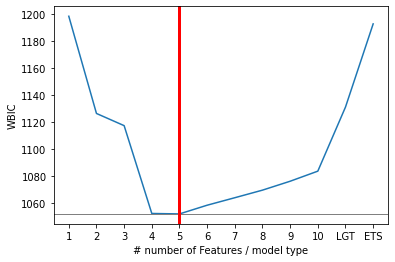

In [7]:
num_reg_ls = list(range(1, NUM_OF_REGRESSORS+1)) + ['LGT','ETS']
plt.plot(num_reg_ls, WBIC_ls, )
plt.axhline(y=min(WBIC_ls), color='grey', linewidth = 1)
plt.axvline(x=NUM_OF_EFFECTIVE_REGRESSORS-1, color='red', linewidth = 3) # because list type is mixed index from 1
plt.ylabel("WBIC")
plt.xlabel("# number of Features / model type")